# Dataset Augmentation

In [1]:
def resize(data, ds_name, x):
    D = open(data, "r")
    L = open(ds_name, "w")
    count = 0  
    for line in D:
        count += 1
        for n in range(x):
            L.write(line)
    L.close()
    D.close()
    return count * x

# Exact Algorithm  

In [2]:
def exact_alg(thres, data):
    frequencies = []
    total_transactions = 0
    total_occurrences = {}
    D = open(data, "r")
    
    # Store total occurrences of each item
    for transaction in D:
        total_transactions += 1
        for item in transaction.split():
            if item != ' ' and item != '\n':
                if item in total_occurrences:
                    total_occurrences[item] += 1
                else:
                    total_occurrences[item] = 1
    
    # Create a list of tuples containing items each with frequency >= the frequency threshold
    for item in total_occurrences:
        frequency = total_occurrences[item]/total_transactions
        if(frequency >= thres):
            tup = (int(item), frequency)
            frequencies.append(tup)
    
    # Sort tuples in increasing order of frequency
    frequencies.sort(key = lambda x:x[1], reverse = True)
    
    return frequencies

In [3]:
import time

def get_x(tuples):
    x = [tup[1] for tup in tuples]
    return x

def get_y(tuples):
    y = [(i + 1) / len(tuples) for i in range(0, len(tuples))]
    return y

def resize_and_run(data, x):
    ds_name = "new_" + data
    dsize = resize(data, ds_name, x)
    
    # calculate time taken
    t0 = time.time()
    frequencies = exact_alg(1/dsize, ds_name)
    t1 = time.time()
    
    print(data[:len(data)-4], "size:", dsize)
    print("Time taken by Exact Algorithm on", data[:len(data)-4], "is ", t1-t0, "seconds")
    
    return frequencies

In [4]:
# Reporting time taken and size for each dataset

kosarak = resize_and_run("kosarak.txt", 3)
accidents = resize_and_run("accidents.txt", 10)
webdocs = resize_and_run("webdocs.txt", 2)

kosarak size: 2970006
Time taken by Exact Algorithm on kosarak is  6.323981046676636 seconds
accidents size: 3401830
Time taken by Exact Algorithm on accidents is  23.12293004989624 seconds
webdocs size: 3384164
Time taken by Exact Algorithm on webdocs is  188.93817806243896 seconds


### Evaluation and Report

From the graph, we see that as we increase `thres`, the fraction of items with `frequency >= thres` decreases. We can infer a couple of things about the dataset from the steepness of this curve. There are many items with very low frequencies and only a few items with high frequencies in `kosarak.txt` and `webdocs.txt`. The graph for `accidents.txt` does not have as steep a curve as `kosarak.txt` or `webdocs.txt`. This implies that items in `accidents.txt` have frequencies that are more evenly ditributed. We can also infer that `kosarak.txt` and `webdocs.txt` have relatively smaller transactions sizes than `accidents.txt` because `accidents.txt` has a higher fraction of items with higher frequencies. Therefore, those items appear in more transactions and the transaction sizes are generally larger. 

We also observe that the curves for `kosarak.txt` and `webdocs.txt` are superimposed on each other.

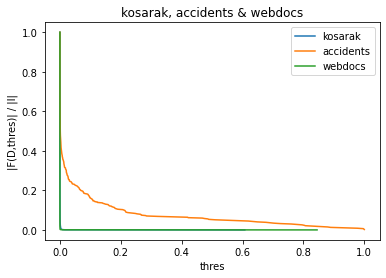

In [5]:
import matplotlib.pyplot as plt

# Plot curves

plt.title('kosarak, accidents & webdocs')
plt.xlabel('thres')
plt.ylabel('|F(D,thres)| / |I|')

kosarak_curve, = plt.plot(get_x(kosarak), get_y(kosarak), label='kosarak')
accidents_curve, = plt.plot(get_x(accidents), get_y(accidents), label='accidents')
webdocs_curve, = plt.plot(get_x(webdocs), get_y(webdocs), label='webdocs')

plt.legend(handles=[kosarak_curve, accidents_curve, webdocs_curve])
plt.show()

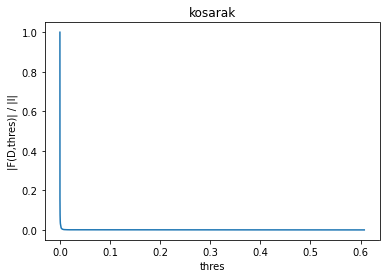

In [6]:
# Plot Kosarak alone

plt.xlabel('thres')
plt.ylabel('|F(D,thres)| / |I|')
plt.title("kosarak")
plt.plot(get_x(kosarak), get_y(kosarak), label='kosarak')
plt.show()

# Sampling Based Algorithm

In [7]:
import math
import random 

def sampling_based_alg(ssize, dsize, delta, thres, data):
    D = open(data, "r")
    frequencies = []
    total_occurrences = {}
    temp_max = 0
    max_tup = 0
    index = 0
    samp_index = 0
    eps = 0
    ds = 0
    new_thres = 0
    res = ()
    
    # Create list of random indexes
    sampleidxs = random.sample(range(1, dsize), ssize)
    sampleidxs.sort()
    
    for transaction in D:
        
        if(samp_index > len(sampleidxs)-1):
            break
        
        # Count occurences only in transactions with sampled indexes
        if index == sampleidxs[samp_index]:
            for item in transaction.split():
                    temp_max += 1
                    if item != ' ' and item != '\n':
                        if item in total_occurrences:
                            total_occurrences[item] += 1
                        else:
                            total_occurrences[item] = 1
                    
            # Update max transaction size value
            if temp_max > max_tup:
                max_tup = temp_max
            temp_max = 0
            samp_index += 1
        index += 1
     
    # Calculate values for the sample
    ds = math.floor(math.log(max_tup, 2) + 1)
    eps = math.sqrt((2 * (ds + math.log(1/delta))) / ssize)
    new_thres = thres - (eps/2)
    
    # Create a list of tuples containing items each with frequency >= the new frequency threshold
    for item in total_occurrences:
        frequency = total_occurrences[item]/ssize
        if(frequency >= new_thres):
            tup = (int(item), frequency)
            frequencies.append(tup)
            
    # Sort the list of tuples in increasing order of frequency
    frequencies.sort(key = lambda x:x[1], reverse = True)
    
    output = (eps, frequencies)
    return output

### Sampling-Based Algorithm Runtime

In [8]:
import time

data = 'new_accidents.txt'
runtimes = {}
outputs = {}
exact_runtime = 0
exact_mod_runtime = 0

s_sizes = [30000, 300000, 1000000, 1500000]
dsize = 3401830
thres = 0.2
delta = 0.1

def timeit(data, ssize, dsize, thres, delta):
    
    t0 = time.time()
    output = sampling_based_alg(ssize, dsize, delta, thres, data)
    t1 = time.time()
    
    res = (math.ceil((t1-t0) * 1000), output)
    return  res
    
for ssize in s_sizes:
    runtimes[ssize] = []
    outputs[ssize] = []
    for i in range(5):
        res = timeit(data, ssize, dsize, thres, delta)
        runtimes[ssize].append(res[0])
        outputs[ssize].append(res[1])

### Exact algorithm runtime

In [9]:
t_exact = 0
t_exact_maxeps = 0
maxeps = 0

for res in outputs[s_sizes[0]]:
    if res[0] > maxeps:
        maxeps = res[0]

t2 = time.time()
exact_res = exact_alg(thres, "new_accidents.txt")
t3 = time.time()
t_exact = math.ceil((t3-t2) * 1000)

t4 = time.time()
exact_maxeps_res = exact_alg((thres - maxeps), "new_accidents.txt")
t5 = time.time()
t_exact_maxeps = math.ceil((t5-t4) * 1000)

In [10]:
# Measures of runtimes across 5 cycles

max_runtimes = []
min_runtimes = []
median_runtimes = []
sorted_runtimes = []

for ssize in s_sizes:
    sorted_runtimes = sorted(runtimes[ssize])
    max_runtimes.append(sorted_runtimes[len(sorted_runtimes) - 1])
    min_runtimes.append(sorted_runtimes[0])
    median_runtimes.append(sorted_runtimes[math.ceil(len(sorted_runtimes)/2)])
    
# Maximum errors and Maximum eps/2
temp_max_err = 0 
temp_max_eps = 0

max_err_run = []

max_err = []
min_err = []
median_err = []
max_eps = []

for ssize in s_sizes:
    for run in outputs[ssize]:
        if run[0] > temp_max_eps:
            temp_max_eps = run[0]
        for n in range(len(run[1])):
            if exact_maxeps_res[n][1] - run[1][n][1] > temp_max_err:
                temp_max_err = exact_maxeps_res[n][1] - run[1][n][1]
        max_err_run.append(temp_max_err)
        temp_max_err = 0
    max_err_run = sorted(max_err_run)
    max_err.append(max_err_run[len(max_err_run) - 1])
    median_err.append(max_err_run[math.ceil(len(max_err_run)/2)])
    min_err.append(max_err_run[0])
    max_eps.append(temp_max_eps/2)
    max_err_run = []
    temp_max_eps = 0

## Evaluation & Report

I used the sample sizes: [30000, 300000, 1000000, 1500000]

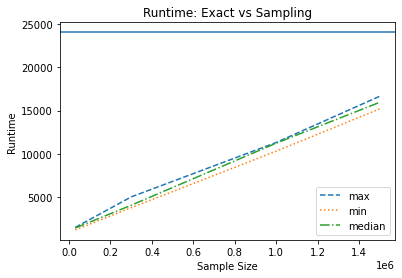

In [11]:
# Plotting Runtimes
plt.title('Runtime: Exact vs Sampling')
plt.xlabel('Sample Size')
plt.ylabel('Runtime')
max_curve, = plt.plot(s_sizes, max_runtimes, '--', label='max')
min_curve, = plt.plot(s_sizes, min_runtimes, ':', label='min')
median_curve, = plt.plot(s_sizes, median_runtimes, '-.', label='median')
plt.axhline(y=t_exact)
plt.legend(handles=[max_curve, min_curve, median_curve])
plt.show()

From the graph, we see that for the sampling-based algorithm, the runtime increases as sample size increases. There is not much difference between the maximum and minimum runtimes for the different trials. However, we observe that the sampling-based algorithm runs much faster than the exact algorithm. 

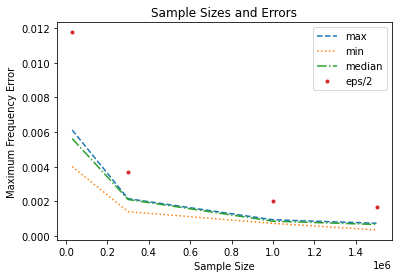

In [12]:
# Plotting Maximum Errors
plt.title('Sample Sizes and Errors')
plt.xlabel('Sample Size')
plt.ylabel('Maximum Frequency Error')
max_curve, = plt.plot(s_sizes, max_err, '--', label='max')
min_curve, = plt.plot(s_sizes, min_err, ':', label='min')
median_curve, = plt.plot(s_sizes, median_err, '-.', label='median')
max_eps_curve, = plt.plot(s_sizes, max_eps, '.', label='eps/2')
plt.legend(handles=[max_curve, min_curve, median_curve, max_eps_curve])
plt.show()

From the graph, we see that the errors in frequencies decrease as the sample size increases. Notably, if the sample size gets too small, the margin of error significantly increases and then gradually decreases with increase in sample size. The graph is initially steep curve because the first sample size is much smaller compared to the higher sample sizes. Because of this we observe a uniform decrease in the theoretical guarranty of error. We note that even with sample size as small as x0.015 the original size, the maximum error does not exceed eps/2.